**ESERCITAZIONE 10:** Risoluzione del problema del commesso viaggiatore (TSP) con il calcolo parallelo. E' disponibile un generatore di numeri pseudo-casuali ottimizzato per il calcolo parallelo.

La novità di questa esercitazione è l'impiego del calcolo parallelo: con la libreria MPI si esegue il medesimo algoritmo in un numero $M_{size}$ di processi (nodi) paralleli, indicizzati dal rango $k \ in \ [0, M_{size} - 1]$, ciascuno dei quali esegue l'algoritmo genetico con differenti iperparametri. Per semplicità di notazione, l'algoritmo genetico di un dato processo è detto continente.

Inoltre, è previsto che, ogni $N_{swap}$ di popolazioni, due continenti, appartenenti a due processi estratti in maniera casuale, si scambino il loro cromosoma migliore. Questo è possibile grazie all'impiego delle operazioni di comunicazione $Send$ e $Recieve$ tra i processi paralleli. Il meccanismo di funzionamento è il seguente: una volta che i nodi paralleli che devono effettuare lo scambio sono stati selezionati e denominati, rispettivamente, $P_1$ e $P_2$, si crea una variabile $buffer$ dove andrà salvato il cromosoma migliore dei relativi nodi. Poi, si invoca la call per il Send del miglior individuo di $P_1$ verso $P_2$ e contemporaneamente la call per il Recieve in $P_2$ di tale vettore, che verrà salvato nel buffer. Poi, è invocato il Recieve in $P_1$ del miglior vettore di $P_2$, che lo salva nel buffer, mentre è chiamato il Send di tale individuo da $P_2$ a $P_2$. Infine, per entrambi i nodi, il cromosoma in posizione $0$ (ovvero quello appena inviato al pocesso complementare) viene sostituito dal buffer temporaneo, che contiene il miglior cromosoma proveniente dall'altro continente. Questo schema tiene conto del fatto che gli operatori Send e Recieve sono delle chiamate bloccanti, ovvero non permettono la prosecuzione dell'esecuzione del codice fino a che la comunicazione non è stata completata, ovvero finchè il vettore non è stato inviato dal primo cromosoma e salvato nel buffer dal cromosoma ricevente.

Una volta che l'esecuzione in parallelo è stata completata, si avranno $M_{size}$ nodi con risultati diversi. Per non complicare la quantità di dati da salvare e analizzare, si sceglie di riportare solamente la statistica del nodo $0$, detto nodo principale. Dal momento che tale processo interagisce con gli altri durante l'esecuzione dell'algoritmo genetico, ci si aspetta di trovare risultati differenti rispetto al caso in cui si esegue solamente tale processo senza parallelizzazione.

**Esercizio 10.1:** Si affronta il problema del commesso viaggiatore con 34 posizioni disposte su una circonferenza. Si usano le località già usate nell'esercitazione 9, mantenendo fissato il seed del generatore di numeri pseudo-casuali per estrarre i punti. Si procede scegliendo il numero di nodi su una collezione ristretta di interi: $M_{size} = [1, 2, 5, 8, 11]$. Ogni nodo presenta un continente con un set di iperparametri $(N, p_m, p_c)$ fissato (rispettivamente: numero di cromosomi della popolazione, probabilità di Mutazione, probabilità di Crossover). Per ogni esecuzione, si sceglie di mantenere $N$ e $p_c$ uguali per tutti i processi paralleli, facendo variare, da un continente all'altro, la probabilità di mutazione con la legge $p_m = p_{start} + \alpha * k$, dove $p_{start}$ è la $p_m$ del nodo $0$. 

La prima esecuzione studiata è in assenza di parallelizzazione ($M_{size} = 1$) e il suo risultato è confrontato con le prestazioni del nodo $0$ in presenza di processi paralleli ($M_{size} > 1$).

Si parte fissando $N = 15$ cromosomi, $p_c = 0.8$ e scegliendo $N_{swap} = 5$. Si decide $p_m = 0.14 + 0.005 * k$. Dunque, verranne salvate le prestazioni del nodo $0$ con $p_m = 0.14$, confrontando le prestazioni tra quando è da solo e quando ha la possibilità di scambiare informazione con i continenti dei nodi paralleli:

[]

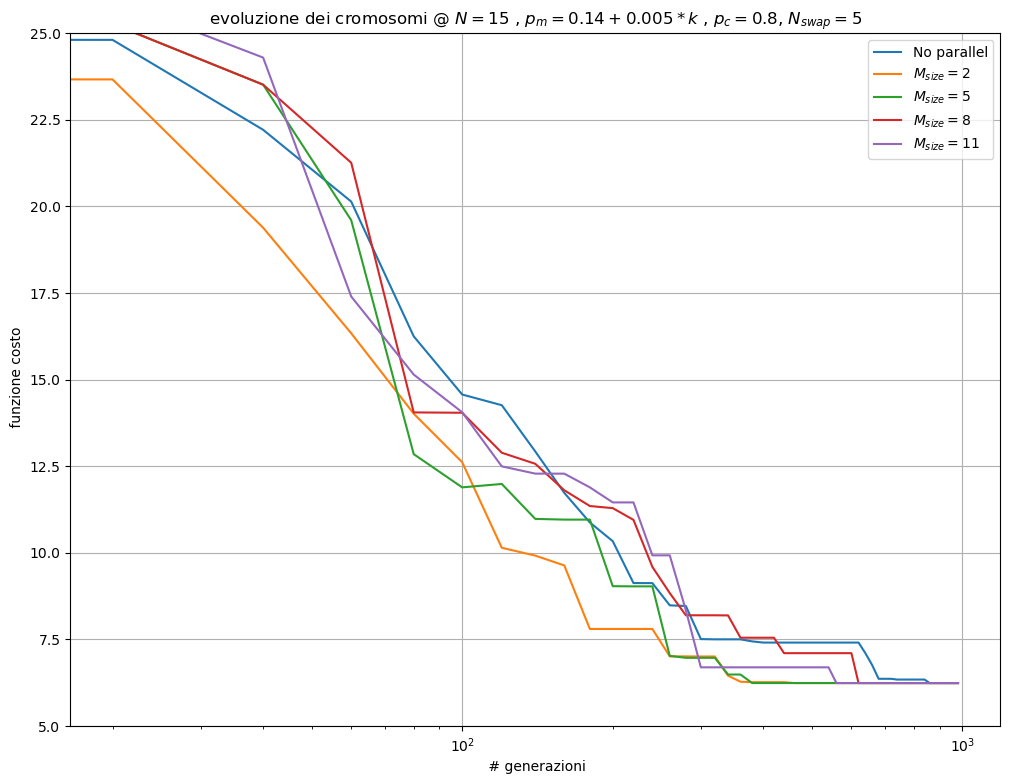

In [1]:
#import asynchat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math as mt

# --- Acquisizione dell'evoluzione dei cromosomi nelle generazioni

#Lettura file
filename_1 = "Codici_finali/Esercizio_10.1/TSP_circ_II/TSP_N_15_SIZE_1/100_Stats.txt"
filename_2 = "Codici_finali/Esercizio_10.1/TSP_circ_II/TSP_N_15_SIZE_2/100_Stats.txt"
filename_5 = "Codici_finali/Esercizio_10.1/TSP_circ_II/TSP_N_15_SIZE_5/100_Stats.txt"
filename_8 = "Codici_finali/Esercizio_10.1/TSP_circ_II/TSP_N_15_SIZE_8/100_Stats.txt"
filename_11 = "Codici_finali/Esercizio_10.1/TSP_circ_II/TSP_N_15_SIZE_11/100_Stats.txt"

G1 = pd.read_table(filename_1, delimiter = "\t" , usecols=(0,1) , names = ('Gen','Best') , header = 0)
G2 = pd.read_table(filename_2, delimiter = "\t" , usecols=(0,1) , names = ('Gen','Best') , header = 0)
G5 = pd.read_table(filename_5, delimiter = "\t" , usecols=(0,1) , names = ('Gen','Best') , header = 0)
G8 = pd.read_table(filename_8, delimiter = "\t" , usecols=(0,1) , names = ('Gen','Best') , header = 0)
G11 = pd.read_table(filename_11, delimiter = "\t" , usecols=(0,1) , names = ('Gen','Best') , header = 0)

#estrarre i dati dalle colonne del file di testo
G1['Gen'] = pd.to_numeric(G1['Gen'] , errors = 'coerce')
G1['Best'] = pd.to_numeric(G1['Best'] , errors = 'coerce')
G2['Best'] = pd.to_numeric(G2['Best'] , errors = 'coerce')
G5['Best'] = pd.to_numeric(G5['Best'] , errors = 'coerce')
G8['Best'] = pd.to_numeric(G8['Best'] , errors = 'coerce')
G11['Best'] = pd.to_numeric(G11['Best'] , errors = 'coerce')

#caricare i dati estratti in rispettivi array
generation_vector = G1['Gen']
best_vector_1 = G1['Best']
best_vector_2 = G2['Best']
best_vector_5 = G5['Best']
best_vector_8 = G8['Best']
best_vector_11 = G11['Best']


plt.figure(figsize = (12,9))
plt.plot(generation_vector,best_vector_1, label = 'No parallel')
plt.plot(generation_vector,best_vector_2, label = '$M_{size} = 2$')
plt.plot(generation_vector,best_vector_5, label = '$M_{size} = 5$')
plt.plot(generation_vector,best_vector_8, label = '$M_{size} = 8$')
plt.plot(generation_vector,best_vector_11, label = '$M_{size} = 11$')
plt.title("evoluzione dei cromosomi @ $N = 15$ , $p_m = 0.14 + 0.005 * k$ , $p_c = 0.8$, $N_{swap} = 5$")
plt.xlabel(" # generazioni")
plt.ylim(5,25)
plt.xscale('log')
plt.ylabel(" funzione costo")
plt.grid(True)
plt.legend()
plt.plot()

Si osserva come la parallelizzazione sia in grado di far convergere più velocemente un continente rispetto al caso non parallelo, condividendo le informazioni di nodi paralleli che utilizzano punti differenti sullo spazio dei parametri. $N = 15$ costituisce una popolazione particolarmente inefficiente: lo scarso numero di individui ostacola la biodiversità della popolazione, portando ad una convergenza lenta, che si realizza solamente dopo $600$ generazioni. Con la parallelizzazione, la convergenza è anticipata a $300$ generazioni.

Si studia in seguito il caso $N = 45$ , $p_m = 0.17 + 0.005 * k $, $p_c = 0.8$ e $N_{swap} = 5$:

[]

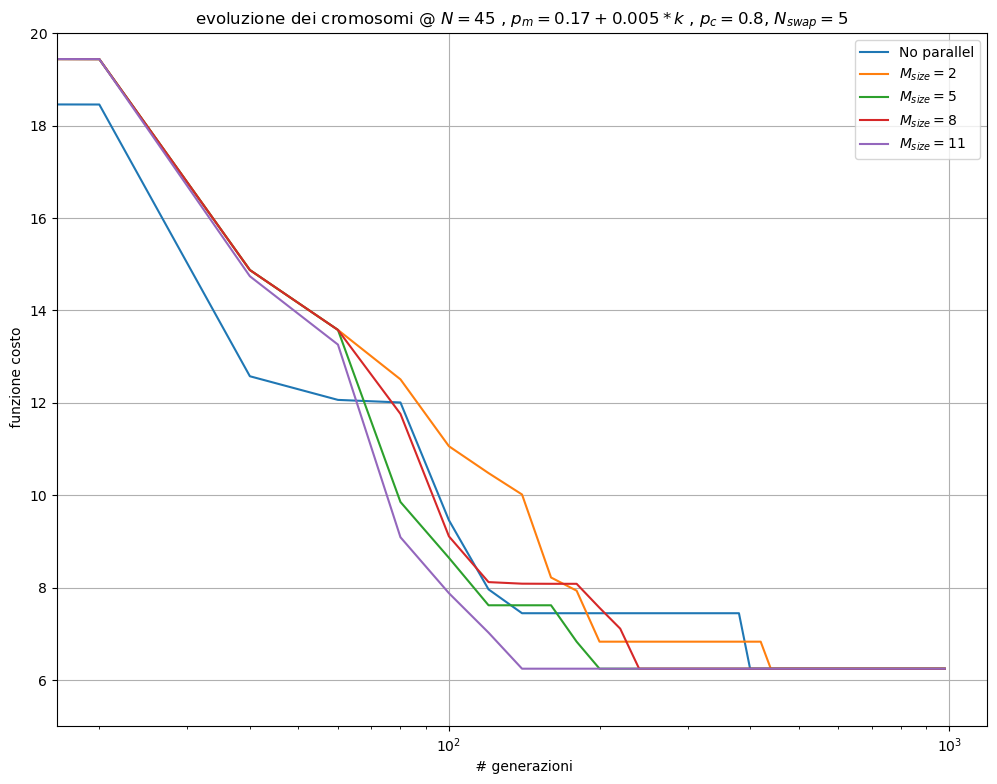

In [3]:
#import asynchat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math as mt

# --- Acquisizione dell'evoluzione dei cromosomi nelle generazioni

#Lettura file
filename_1 = "Codici_finali/Esercizio_10.1/TSP_circ_I/TSP_N_45_SIZE_1/100_Stats.txt"
filename_2 = "Codici_finali/Esercizio_10.1/TSP_circ_I/TSP_N_45_SIZE_2/100_Stats.txt"
filename_5 = "Codici_finali/Esercizio_10.1/TSP_circ_I/TSP_N_45_SIZE_5/100_Stats.txt"
filename_8 = "Codici_finali/Esercizio_10.1/TSP_circ_I/TSP_N_45_SIZE_8/100_Stats.txt"
filename_11 = "Codici_finali/Esercizio_10.1/TSP_circ_I/TSP_N_45_SIZE_11/100_Stats.txt"

G1 = pd.read_table(filename_1, delimiter = "\t" , usecols=(0,1) , names = ('Gen','Best') , header = 0)
G2 = pd.read_table(filename_2, delimiter = "\t" , usecols=(0,1) , names = ('Gen','Best') , header = 0)
G5 = pd.read_table(filename_5, delimiter = "\t" , usecols=(0,1) , names = ('Gen','Best') , header = 0)
G8 = pd.read_table(filename_8, delimiter = "\t" , usecols=(0,1) , names = ('Gen','Best') , header = 0)
G11 = pd.read_table(filename_11, delimiter = "\t" , usecols=(0,1) , names = ('Gen','Best') , header = 0)

#estrarre i dati dalle colonne del file di testo
G1['Gen'] = pd.to_numeric(G1['Gen'] , errors = 'coerce')
G1['Best'] = pd.to_numeric(G1['Best'] , errors = 'coerce')
G2['Best'] = pd.to_numeric(G2['Best'] , errors = 'coerce')
G5['Best'] = pd.to_numeric(G5['Best'] , errors = 'coerce')
G8['Best'] = pd.to_numeric(G8['Best'] , errors = 'coerce')
G11['Best'] = pd.to_numeric(G11['Best'] , errors = 'coerce')

#caricare i dati estratti in rispettivi array
generation_vector = G1['Gen']
best_vector_1 = G1['Best']
best_vector_2 = G2['Best']
best_vector_5 = G5['Best']
best_vector_8 = G8['Best']
best_vector_11 = G11['Best']


plt.figure(figsize = (12,9))
plt.plot(generation_vector,best_vector_1, label = 'No parallel')
plt.plot(generation_vector,best_vector_2, label = '$M_{size} = 2$')
plt.plot(generation_vector,best_vector_5, label = '$M_{size} = 5$')
plt.plot(generation_vector,best_vector_8, label = '$M_{size} = 8$')
plt.plot(generation_vector,best_vector_11, label = '$M_{size} = 11$')
plt.title("evoluzione dei cromosomi @ $N = 45$ , $p_m = 0.17 + 0.005 * k$ , $p_c = 0.8$, $N_{swap} = 5$")
plt.xlabel(" # generazioni")
plt.ylim(5,20)
plt.xscale('log')
plt.ylabel(" funzione costo")
plt.grid(True)
plt.legend()
plt.plot()

Il miglioramento del tempo di convergenza si osserva anche nel caso $N = 45$. Bisogna però specificare che i nodi lavorano in una regione dello spazio dei parametri in cui è risaputo esserci un algoritmo ottimale (nell'Esercizione 9 si era identificato $N = 45$, $p_m = 0.17$, $p_c = 0.8$). Dunque, l'unica preliminare conclusione che, da questi due grafici, si può trarre è che la parallelizzazione è in grado di far raggiungere la convergenza partendo da un nodo principale con dei parametri nell'intorno locale di quelli ottimali. Questo permette di evitare di ricercare il punto esatto nello spazio degli iperparametri che porta a convergenza entro poche centinaia di generazioni, limitandosi a esplorare punti nel suo intorno, risparmiando significativamnete tempo computazionale.

Si studia ora il caso dell'algoritmo genetico per i punti generati all'interno del quadrato di lato unitario. Si sceglie $N = 100$, $p_m = 0.11 + 0.001 *rank$ , $p_c = 0.79 + 0.001 * k$, $N_{swap} = 5$:

[]

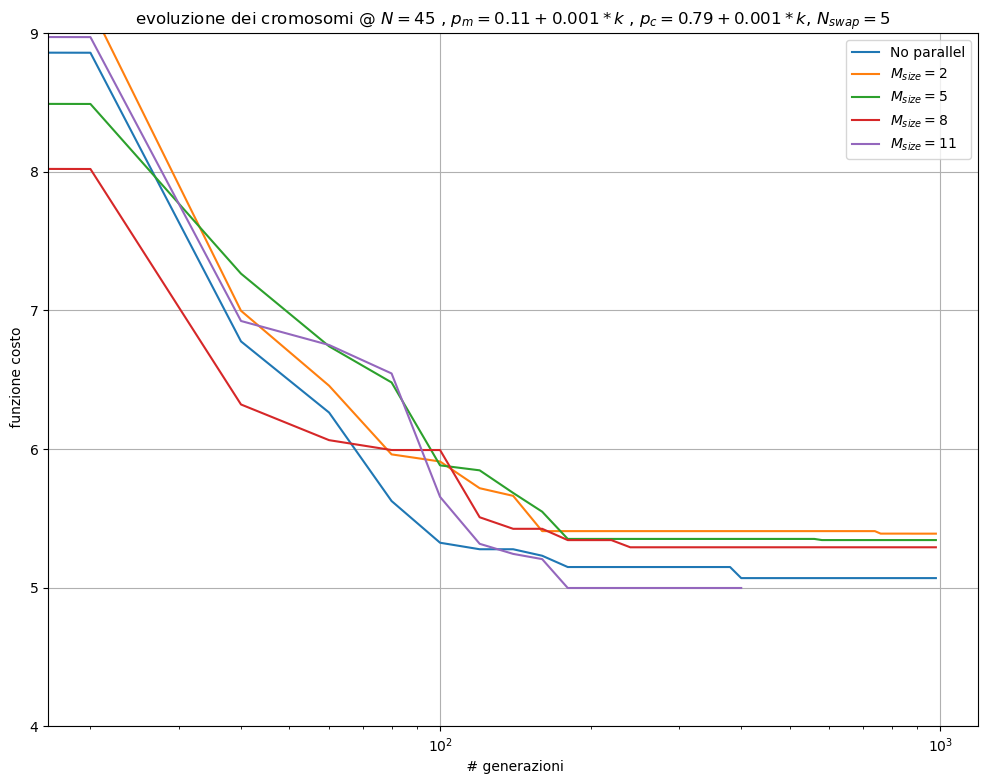

In [4]:
#import asynchat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math as mt

# --- Acquisizione dell'evoluzione dei cromosomi nelle generazioni

#Lettura file
filename_1 = "Codici_finali/Esercizio_10.1/TSP_sqr_I/TSP_N_100_SIZE_1/100_Stats.txt"
filename_2 = "Codici_finali/Esercizio_10.1/TSP_sqr_I/TSP_N_100_SIZE_2/100_Stats.txt"
filename_5 = "Codici_finali/Esercizio_10.1/TSP_sqr_I/TSP_N_100_SIZE_5/100_Stats.txt"
filename_8 = "Codici_finali/Esercizio_10.1/TSP_sqr_I/TSP_N_100_SIZE_8/100_Stats.txt"
filename_11 = "Codici_finali/Esercizio_10.1/TSP_sqr_I/TSP_N_100_SIZE_11/100_Stats.txt"

G1 = pd.read_table(filename_1, delimiter = "\t" , usecols=(0,1) , names = ('Gen','Best') , header = 0)
G2 = pd.read_table(filename_2, delimiter = "\t" , usecols=(0,1) , names = ('Gen','Best') , header = 0)
G5 = pd.read_table(filename_5, delimiter = "\t" , usecols=(0,1) , names = ('Gen','Best') , header = 0)
G8 = pd.read_table(filename_8, delimiter = "\t" , usecols=(0,1) , names = ('Gen','Best') , header = 0)
G11 = pd.read_table(filename_11, delimiter = "\t" , usecols=(0,1) , names = ('Gen','Best') , header = 0)

#estrarre i dati dalle colonne del file di testo
G1['Gen'] = pd.to_numeric(G1['Gen'] , errors = 'coerce')
G1['Best'] = pd.to_numeric(G1['Best'] , errors = 'coerce')
G2['Best'] = pd.to_numeric(G2['Best'] , errors = 'coerce')
G5['Best'] = pd.to_numeric(G5['Best'] , errors = 'coerce')
G8['Best'] = pd.to_numeric(G8['Best'] , errors = 'coerce')
G11['Gen'] = pd.to_numeric(G11['Gen'] , errors = 'coerce')
G11['Best'] = pd.to_numeric(G11['Best'] , errors = 'coerce')

#caricare i dati estratti in rispettivi array
generation_vector = G1['Gen']
generation_vector_11 = G11['Gen']
best_vector_1 = G1['Best']
best_vector_2 = G2['Best']
best_vector_5 = G5['Best']
best_vector_8 = G8['Best']
best_vector_11 = G11['Best']


plt.figure(figsize = (12,9))
plt.plot(generation_vector,best_vector_1, label = 'No parallel')
plt.plot(generation_vector,best_vector_2, label = '$M_{size} = 2$')
plt.plot(generation_vector,best_vector_5, label = '$M_{size} = 5$')
plt.plot(generation_vector,best_vector_8, label = '$M_{size} = 8$')
plt.plot(generation_vector_11,best_vector_11, label = '$M_{size} = 11$')
plt.title("evoluzione dei cromosomi @ $N = 45$ , $p_m = 0.11 + 0.001 * k$ , $p_c = 0.79 + 0.001*k$, $N_{swap} = 5$")
plt.xlabel(" # generazioni")
plt.ylim(4,9)
plt.xscale('log')
plt.ylabel(" funzione costo")
plt.grid(True)
plt.legend()
plt.plot()

Dal grafico appena mostrato, è evidente come la parallelizzazione non fornisce la garanzia di giungere a convergenza dopo $1000$ generazioni partendo da un punto non ottimale dello spazio degli iperparametri, nel caso in cui le prestazioni siano particolarmente sensibili alla posizione su quest'ultimo, come nell'esempio dei punti sul quadrato. Infatti, dall'Esercitazione 9 si era identificata la funzione costo di convergenza come $\approx 4.98$, mentre si osserva che in questo caso, pur usando la parallelizzazione, non si arriva mai a tale valore.

**Esercizio 10.2:** Si risolve il problema del commesso viaggiatore per le posizioni corrispondenti alle 110 città capoluogo di provincia italiane. Oltre a differire per il numero di punti su cui ottimizzare il percorso, questo problema si differenzia da quello delle 34 località anche per la topologia della varietà su cui le posizioni sono disposte. In questo caso, si hanno 110 punti disposti su una circonferenza di raggio $R$ (lo si approssima al raggio medio della terra $6371 \ km$), di cui sono fornite le coordinate di latitudine e longitudine. E' necessario innanzitutto convertire queste coordinate in termini di $(\theta, \phi)$, rispettivamente l'angolo polare e l'angolo azimutale, convertendo poi il risultato da gradi a radianti:

$$\theta = \pi/2 - latitudine$$
$$\phi = longitudine$$

Dopodichè, è necessario definire la metrica per misurare la distanza $d$, percorsa sulla superficie sferica, tra due punti di coordinate $(\theta_1 , \phi_1)$ e $(\theta_2, \phi_2)$. Tale distanza sarà pari alla quadratura tra le componenti dell'arco che separa i due punti, rispettivamente lungo le direzioni radiale e azimutale:

$$l_{\theta} = R * (\theta_2 - \theta_1)$$
$$l_{\phi} = R * sin(\frac{\theta_2 + \theta_1}{2}) * (\phi_2 - \phi_1)$$
$$d(\theta_1,\theta_2,\phi_1,\phi_2) = \sqrt{l_{\theta}^2 + l_{\phi}^2}$$

Inoltre, siccome il tempo necessario ad eseguire i calcoli è particolarmente esteso, sarebbe alquanto sconveniente far partire la simulazione di tutti i casi $M_{size} \ in \ [1,2,5,8,11]$ da una popolazione di cromosomi generati casualmente attraverso permutazioni aleatorie della sequenza $[1, 2, 3, ..., 109, 110]$. Piuttosto, si è ricercato un individuo che generasse un cammino parzialmente ottimizzato ($\sum_i^{110} d_i < 10000 \ km$) attraverso successive simulazioni e lo si è inserito nella popolazione iniziale appena generata, facendolo comparire nei primi 20 cromosomi. In questo modo tutte le successive simulazioni partono già parzialmente ottimizzate, giungendo a generare individui sempre più efficienti nel minor tempo possibile.

Si è riportato il cammino percorso da tale individuo di partenza, che comporta un cammino totale pari a $7877 \ km$:

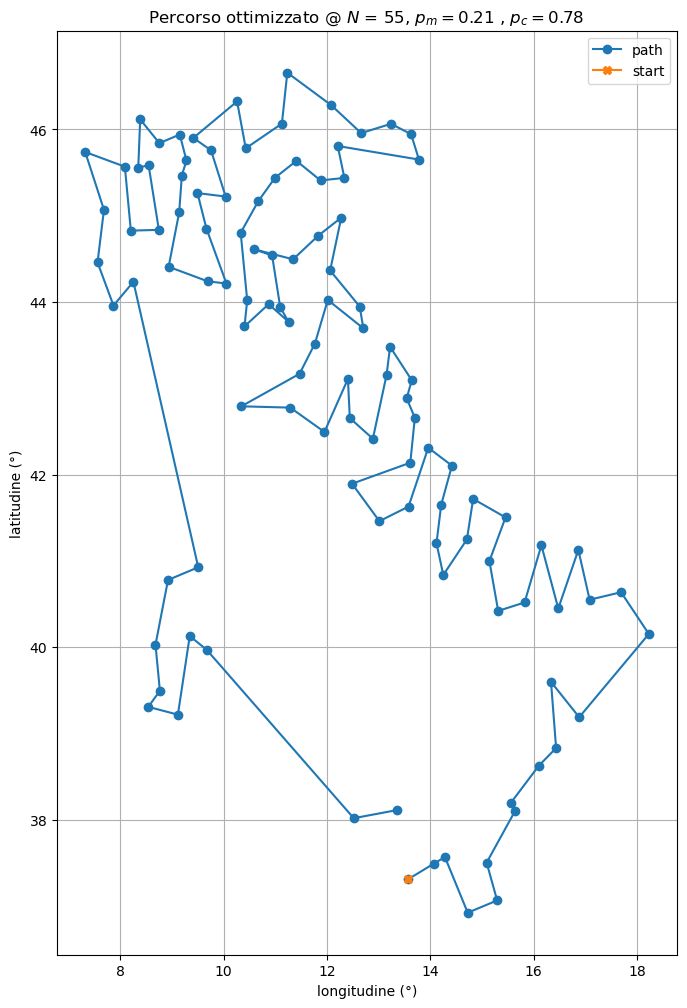

L'ordine dei punti da visitare per minimizzare il cammino è il seguente: 
[  1  20  32  78  91  24  80  56 108  25  28  30  47  18  93   9  55  10
  76  86   8  36  21  12  60  23  43  26  71  38  46  84  45  94   6  33
   3  52  82  95  69 110  41  49  90   5  37  70  83  79  85  34  15  81
  58  77  35  74  73  51  67  53 107 109  65 104 100 101  40 102  75  11
  16  99  17  92  48  13  29  50  72  54  44  39  68  57  59  27 103 105
 106  61   2   7  14   4  96  31  42  89  63  88  64  87  22  19  62  97
  98  66]


In [9]:
# --- Acquisizione della sequenza di numeri dell'esemplare finale

#Lettura file
filename = "Start_sequence.txt"
C = pd.read_table(filename, delimiter = "\t" , usecols=(0,1,2) , names = ('#','X','Y'))

#estrarre i dati dalle colonne del file di testo
C['#'] = pd.to_numeric(C['#'] , errors = 'coerce')
C['X'] = pd.to_numeric(C['X'] , errors = 'coerce')
C['Y'] = pd.to_numeric(C['Y'] , errors = 'coerce')

#caricare i dati estratti in rispettivi array
city_vector = C['#']
X_vector = C['X']
Y_vector = C['Y']

plt.figure(figsize = (8,12))
plt.plot(X_vector , Y_vector , marker = 'o' ,  linestyle = '-',label='path' )
plt.plot(X_vector[0] , Y_vector[0] , marker = 'X' ,  linestyle = '-',label = 'start')
plt.title("Percorso ottimizzato @ $N$ = 55, $p_m = 0.21$ , $p_c = 0.78$ ")
plt.xlabel('longitudine (°)')
plt.ylabel('latitudine (°)')
plt.legend()
#plt.xlim(-1,1)
#plt.ylim(-1,1)
plt.grid(True)
plt.show()

print("L'ordine dei punti da visitare per minimizzare il cammino è il seguente: ")
print(np.array(city_vector))

[]

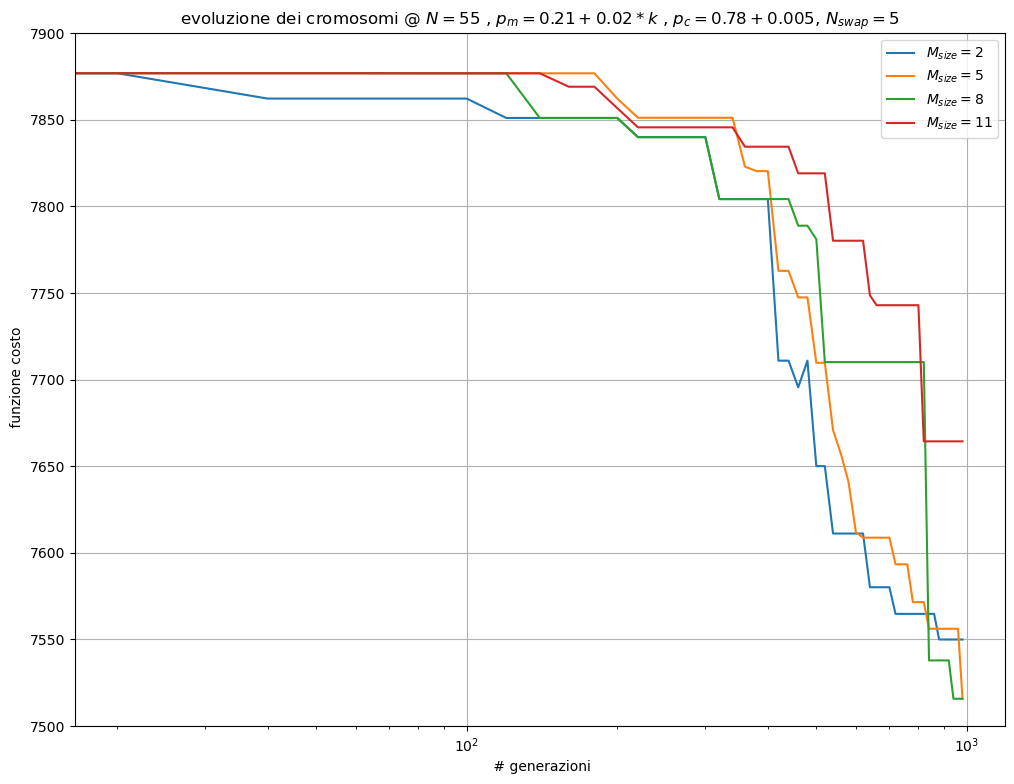

In [2]:
#import asynchat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math as mt

# --- Acquisizione dell'evoluzione dei cromosomi nelle generazioni

#Lettura file
filename_2 = "Codici_finali/Esercizio_10.2/N_55_SIZE_2/100_Stats.txt"
filename_5 = "Codici_finali/Esercizio_10.2/N_55_SIZE_5/100_Stats.txt"
filename_8 = "Codici_finali/Esercizio_10.2/N_55_SIZE_8/100_Stats.txt"
filename_11 = "Codici_finali/Esercizio_10.2/N_55_SIZE_11/100_Stats.txt"

G2 = pd.read_table(filename_2, delimiter = "\t" , usecols=(0,1) , names = ('Gen','Best') , header = 0)
G5 = pd.read_table(filename_5, delimiter = "\t" , usecols=(0,1) , names = ('Gen','Best') , header = 0)
G8 = pd.read_table(filename_8, delimiter = "\t" , usecols=(0,1) , names = ('Gen','Best') , header = 0)
G11 = pd.read_table(filename_11, delimiter = "\t" , usecols=(0,1) , names = ('Gen','Best') , header = 0)

#estrarre i dati dalle colonne del file di testo
G2['Gen'] = pd.to_numeric(G2['Gen'] , errors = 'coerce')
G2['Best'] = pd.to_numeric(G2['Best'] , errors = 'coerce')
G5['Best'] = pd.to_numeric(G5['Best'] , errors = 'coerce')
G8['Best'] = pd.to_numeric(G8['Best'] , errors = 'coerce')
G11['Best'] = pd.to_numeric(G11['Best'] , errors = 'coerce')

#caricare i dati estratti in rispettivi array
generation_vector = G2['Gen']
best_vector_2 = G2['Best']
best_vector_5 = G5['Best']
best_vector_8 = G8['Best']
best_vector_11 = G11['Best']

plt.figure(figsize = (12,9))
plt.plot(generation_vector,best_vector_2, label = '$M_{size} = 2$')
plt.plot(generation_vector,best_vector_5, label = '$M_{size} = 5$')
plt.plot(generation_vector,best_vector_8, label = '$M_{size} = 8$')
plt.plot(generation_vector,best_vector_11, label = '$M_{size} = 11$')
plt.title("evoluzione dei cromosomi @ $N = 55$ , $p_m = 0.21 + 0.02 * k$ , $p_c = 0.78 + 0.005$, $N_{swap} = 5$")
plt.xlabel(" # generazioni")
plt.ylim(7500,7900)
plt.xscale('log')
plt.ylabel(" funzione costo")
plt.grid(True)
plt.legend()
plt.plot()

Viene proposta la sequenza di località ottenuta per $M_{size} = 2$, con un cammino pari a $7550 \ km$:

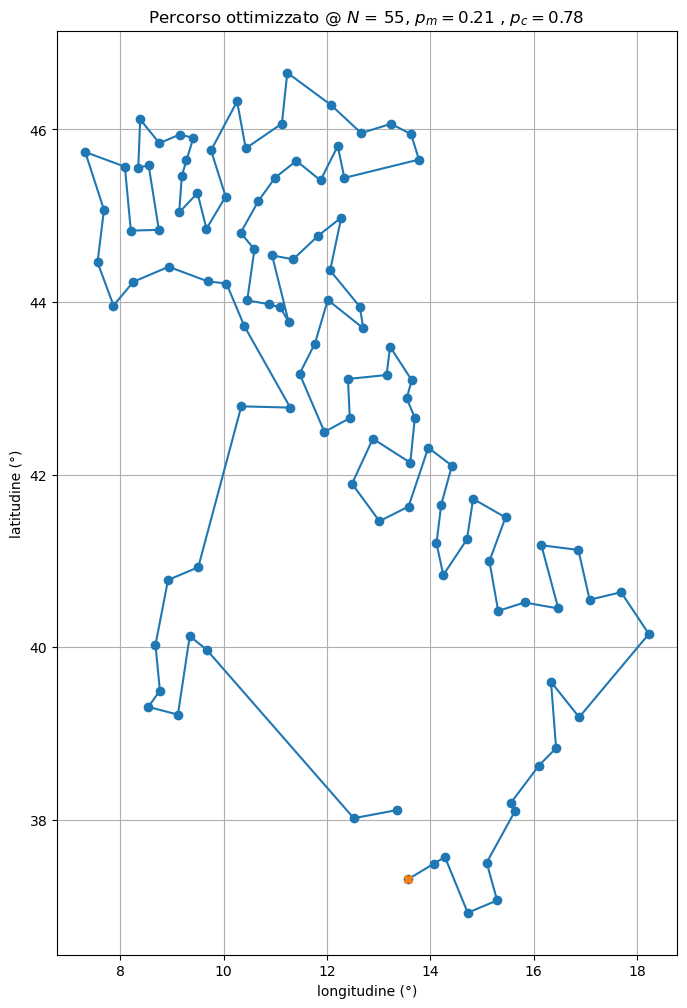

L'ordine dei punti da visitare per minimizzare il cammino è il seguente: 
[  1  20  32  78  91  24  80  56 108  25  28  30  47  18  93   9  10  55
  76  86   8  36  21  12  60  23  43  26  71  38  46  84  82  45  94   6
  33   3  52  69  95 110  90   5  37  70  83  79  85  34  15  58  35  77
  74  51  81  67  53 107 109  65 100 104 101  40 102  75  11  16  99  17
  92  13  29  72  50  68  57  59  48  27 103 105 106  61   2   7  14   4
  96  31  42  89  39  44  54  73  41  49  63  88  64  87  22  19  62  97
  98  66]


In [10]:
# --- Acquisizione della sequenza di numeri dell'esemplare finale

#Lettura file
filename = "Codici_finali/Esercizio_10.2/N_55_SIZE_2/100_Final_sequence.txt"
C = pd.read_table(filename, delimiter = "\t" , usecols=(0,1,2) , names = ('#','X','Y'))

#estrarre i dati dalle colonne del file di testo
C['#'] = pd.to_numeric(C['#'] , errors = 'coerce')
C['X'] = pd.to_numeric(C['X'] , errors = 'coerce')
C['Y'] = pd.to_numeric(C['Y'] , errors = 'coerce')

#caricare i dati estratti in rispettivi array
city_vector = C['#']
X_vector = C['X']
Y_vector = C['Y']

plt.figure(figsize = (8,12))
plt.plot(X_vector , Y_vector , marker = 'o' ,  linestyle = '-',label='path' )
plt.plot(X_vector[0] , Y_vector[0] , marker = 'X' ,  linestyle = '-',label = 'start')
plt.title("Percorso ottimizzato @ $N$ = 55, $p_m = 0.21$ , $p_c = 0.78$ ")
plt.xlabel('longitudine (°)')
plt.ylabel('latitudine (°)')
#plt.xlim(-1,1)
#plt.ylim(-1,1)
plt.grid(True)
plt.show()

print("L'ordine dei punti da visitare per minimizzare il cammino è il seguente: ")
print(np.array(city_vector))